<a href="https://colab.research.google.com/github/amfakh/Dicoding-Submission/blob/master/Pentree%20Bank%20modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p /resources/data
!wget -q -O /resources/data/ptb.zip https://ibm.box.com/shared/static/z2yvmhbskc45xd2a9a4kkn6hg4g4kj5r.zip
!unzip -o /resources/data/ptb.zip -d /resources/
!cp /resources/ptb/reader.py .

Archive:  /resources/data/ptb.zip
   creating: /resources/ptb/
  inflating: /resources/ptb/reader.py  
   creating: /resources/__MACOSX/
   creating: /resources/__MACOSX/ptb/
  inflating: /resources/__MACOSX/ptb/._reader.py  
  inflating: /resources/__MACOSX/._ptb  


In [ ]:
import reader

In [ ]:
!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
!tar xzf simple-examples.tgz -C /resources/data/

--2019-11-19 12:01:42--  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34869662 (33M) [application/x-gtar]
Saving to: ‘simple-examples.tgz’

simple-examples.tgz 100%[===================>]  33.25M  3.44MB/s    in 9.9s    

2019-11-19 12:01:52 (3.37 MB/s) - ‘simple-examples.tgz’ saved [34869662/34869662]



In [ ]:
# Direktori menuju dataset yang barusan kita download
data_path = "/resources/data/simple-examples/data/"
# Mengambil data
raw_data = reader.ptb_raw_data(data_path)
# memisahkan data menjadi 5 buah tipe
train_data, valid_data, test_data, vocabulary, word_to_id = raw_data

In [ ]:
# key dan value dalam dictionary dibalik
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))

In [ ]:
# lihat kata ke 100 sampai 110
print(" ".join([id_to_word[x] for x in train_data[100:120]]))

workers exposed to it more than N years ago researchers reported <eos> the asbestos fiber <unk> is unusually <unk> once


In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))
print(vocabulary)

929589
73760
82430
10000


In [ ]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import argparse

In [ ]:
class KerasBatchGenerator(object):
    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

In [ ]:
def generate(self):
    x = np.zeros((self.batch_size, self.num_steps))
    y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
    while True:
        for i in range(self.batch_size):
            if self.current_idx + self.num_steps >= len(self.data):
                # reset the index back to the start of the data set
                self.current_idx = 0
            x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
            temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
            # convert all of temp_y into a one hot representation
            y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
            self.current_idx += self.skip_step
        yield x, y

In [ ]:
num_steps = 30
batch_size = 30
hidden_size = 1000

iterator = reader.ptb_iterator(train_data, batch_size, num_steps)
x, y = iterator.__next__()

print('x, input data: {}'.format(x.shape))
print('y, target data: {}'.format(y.shape))

x, input data: (30, 30)
y, target data: (30, 30)


In [ ]:
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

In [ ]:
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
# model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))

optimizer = Adam()

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['categorical_accuracy'])

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 30, 1000)          8004000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 1000)          8004000   
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 10000)         10010000  
_________________________________________________________________
activation (Activation)      (None, 30, 10000)         0         
Total params: 36,018,000
Trainable params: 36,018,000
N

In [ ]:
checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

In [ ]:
num_epochs = 50

import time
from keras.callbacks import EarlyStopping

print("--- Start ---")
start_time = time.time()


es = EarlyStopping(monitor='val_loss', mode='min', 
                   verbose=1, patience=5)

history = model.fit_generator(generate(train_data_generator), len(train_data)//(batch_size*num_steps), num_epochs,
                    validation_data=generate(valid_data_generator),
                    validation_steps=len(valid_data)//(batch_size*num_steps)
                    ,callbacks=[es]
                    )
# model.fit_generator(train_data_generator.generate(), 2000, num_epochs,
#                     validation_data=valid_data_generator.generate(),
#                     validation_steps=10)

print("--- Finish ---")
print("--- %s seconds ---" % (time.time() - start_time))
model.save(data_path + "final_model.hdf5")

--- Start ---
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1032/1032 [==============================] - 201s 195ms/step - loss: 6.5502 - categorical_accuracy: 0.0854 - val_loss: 5.8463 - val_categorical_accuracy: 0.1481
Epoch 2/50
1032/1032 [==============================] - 197s 191ms/step - loss: 5.5599 - categorical_accuracy: 0.1730 - val_loss: 5.4109 - val_categorical_accuracy: 0.1901
Epoch 3/50
1032/1032 [==============================] - 197s 191ms/step - loss: 5.1163 - categorical_accuracy: 0.2048 - val_loss: 5.2089 - val_categorical_accuracy: 0.2104
Epoch 4/50
1032/1032 [==============================] - 197s 191ms/step - loss: 4.8073 - categorical_accuracy: 0.2246 - val_loss: 5.1453 - val_categorical_accuracy: 0.2187
Epoch 5/50
1032/1032 [==============================] - 197s 190ms/step - loss: 4.5638 - categorical_accuracy: 0.2398 - val_loss: 5.1129 - val_categorical_accuracy: 0.2224
Epoch 6/50
1032/1032 [==========

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

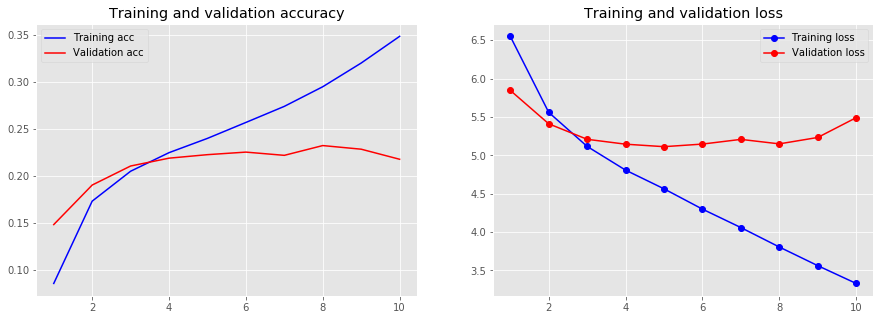

In [ ]:
plot_history(history)

In [ ]:
loss = history.history['loss']
perp = tf.exp(loss)

index = []
length = len(loss)
for i in range(length):
  index.append(i+1)

epoch = np.array(index) + 0.

Perplexity: [699.41504  259.7849   166.71286  122.40642   95.94646   73.638824
  57.907833  44.952873  35.260998  27.961384]


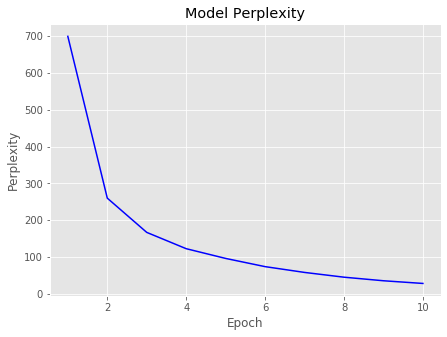

In [ ]:
with tf.Session() as sess:
    print('Perplexity:', sess.run(perp)) 
    plt.figure(figsize=(7, 5))
    plt.plot(epoch, sess.run(perp), color = 'b')  
    plt.title("Model Perplexity")  
    plt.xlabel("Epoch")  
    plt.ylabel("Perplexity")  
  
    plt.show() 

In [ ]:
dummy_iters = 40
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocabulary,
                                                  skip_step=1)
print("Training data:")
for i in range(dummy_iters):
    dummy = next(generate(example_training_generator))
num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(generate(example_training_generator))
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    true_print_out += id_to_word[train_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += id_to_word[predict_word] + " "
print(true_print_out)
print(pred_print_out)
# test data set
dummy_iters = 40
example_test_generator = KerasBatchGenerator(test_data, num_steps, 1, vocabulary,
                                                  skip_step=1)
print("Test data:")
for i in range(dummy_iters):
    dummy = next(generate(example_training_generator))
num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(generate(example_training_generator))
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps - 1, :])
    true_print_out += id_to_word[test_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += id_to_word[predict_word] + " "
print(true_print_out)
print(pred_print_out)



Training data:
Actual words: director of this british industrial conglomerate <eos> a form of 
Predicted words: director of this maker company conglomerate <eos> the <unk> of 
Test data:
Actual words: futures <eos> the N stock specialist firms on the big 
Predicted words: the is the <unk> of a more <unk> to <unk> 
